# Imports

In [20]:
import pandas as pd
from scipy.stats import chi2_contingency, f_oneway, kruskal
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Helper functions

In [2]:
# Column names of interest
columns_of_interest = [
    # Demographic and other relevant columns
    'QID6', 'QID7', 'QID8', 'QID9', 'QID10', 'QID11', 
    # Trustworthiness columns
    'QID25_1', 'QID25_6', 'QID25_7', 'QID25_8', 'QID25_9', 'QID25_10', 'QID25_11', 'QID25_12', 'QID25_13', 'QID25_14', 'QID25_15', 'QID25_16', 
    # Perceived Clarity columns
    'QID26_1', 'QID26_5', 'QID26_6', 'QID26_7', 'QID26_8', 'QID26_9', 
    # Subsequent Interaction columns
    'QID27_1', 'QID27_5', 'QID27_6', 'QID27_7', 'QID27_8', 'QID27_9', 'QID27_10', 'QID27_11', 'QID27_12',
    # Open question
    'QID29_TEXT'
]

# Additional columns for group assignment
additional_columns = [
    'FL_22_DO_Facialrecognition-Lowtransparency', 'FL_22_DO_Facialrecognition-Hightransparency', 
    'FL_17_DO_Pin-Lowtransparency', 'FL_17_DO_Pin-Hightransparency'
]

# Combining all columns of interest
all_columns = columns_of_interest + additional_columns


# Renaming dictionary for readability
rename_dict = {
    # Demographic questions
    'QID6': 'demographic_q1', 
    'QID7': 'demographic_q2', 
    'QID8': 'demographic_q3', 
    'QID9': 'demographic_q4', 
    'QID10': 'demographic_q5', 
    'QID11': 'demographic_q6',
    # Trustworthiness questions
    'QID25_1': 'trustworthiness_1', 'QID25_6': 'trustworthiness_6', 'QID25_7': 'trustworthiness_7', 'QID25_8': 'trustworthiness_8', 'QID25_9': 'trustworthiness_9', 'QID25_10': 'trustworthiness_10', 'QID25_11': 'trustworthiness_11', 'QID25_12': 'trustworthiness_12', 'QID25_13': 'trustworthiness_13', 'QID25_14': 'trustworthiness_14', 'QID25_15': 'trustworthiness_15', 'QID25_16': 'trustworthiness_16',
    # Percieved clarity questions
    'QID26_1': 'Perceived_Clarity_1', 'QID26_5': 'Perceived_Clarity_5', 'QID26_6': 'Perceived_Clarity_6', 'QID26_7': 'Perceived_Clarity_7', 'QID26_8': 'Perceived_Clarity_8', 'QID26_9': 'Perceived_Clarity_9',
    # Subsequent user behavior questions
    'QID27_1': 'Subsequent_Interaction_1', 'QID27_5': 'Subsequent_Interaction_5', 'QID27_6': 'Subsequent_Interaction_6', 'QID27_7': 'Subsequent_Interaction_7', 'QID27_8': 'Subsequent_Interaction_8', 'QID27_9': 'Subsequent_Interaction_9', 'QID27_10': 'Subsequent_Interaction_10', 'QID27_11': 'Subsequent_Interaction_11', 'QID27_12': 'Subsequent_Interaction_12',
    # Open text question
    'QID29_TEXT': 'open_question'
}

# Mapping Likert scale responses to numerical values
likert_mapping = {
    'Strongly Disagree': 1,
    'Disagree': 2,
    'Somewhat Disagree': 3,
    'Neither Agree nor Disagree': 4,
    'Somewhat Agree': 5,
    'Agree': 6,
    'Strongly Agree': 7
}

# Trustworthiness questions
trustworthiness_questions = [
    'trustworthiness_1', 'trustworthiness_6', 'trustworthiness_7', 
    'trustworthiness_8', 'trustworthiness_9', 'trustworthiness_10', 
    'trustworthiness_11', 'trustworthiness_12', 'trustworthiness_13', 
    'trustworthiness_14', 'trustworthiness_15', 'trustworthiness_16'
]

# Perceived Clarity questions
perceived_clarity_questions = [
    'Perceived_Clarity_1', 'Perceived_Clarity_5', 'Perceived_Clarity_6', 
    'Perceived_Clarity_7', 'Perceived_Clarity_8', 'Perceived_Clarity_9'
]

# Subsequent Interaction questions
subsequent_interaction_questions = [
    'Subsequent_Interaction_1', 'Subsequent_Interaction_5', 'Subsequent_Interaction_6',
    'Subsequent_Interaction_7', 'Subsequent_Interaction_8', 'Subsequent_Interaction_9',
    'Subsequent_Interaction_10', 'Subsequent_Interaction_11', 'Subsequent_Interaction_12'
]

# Category grouping
categories = {
    'Trustworthiness': trustworthiness_questions,
    'Perceived_Clarity': perceived_clarity_questions,
    'Subsequent_Interaction': subsequent_interaction_questions
}

# Data pre-processing

In [3]:
original_data = pd.read_csv('results.csv')

# Filter for finished participants
finished_participants = original_data[original_data['finished'] == 'True']

# Columns to drop
columns_to_drop = ['startDate', 'endDate', 'status', 'ipAddress', 'progress', 
                   'duration', 'finished', 'recordedDate', '_recordId', 'recipientLastName', 'recipientFirstName', 'recipientEmail', 'externalDataReference','locationLatitude','locationLongitude','distributionChannel','userLanguage','QID4','QID39','QID15_TEXT',
                   'QID13_TEXT','QID23_1','QID23_2','QID17_TEXT','']

# Drop specified columns
finished_participants = finished_participants.drop(columns=columns_to_drop, errors='ignore')


# Selecting and mapping the relevant columns
relevant_columns = [
    'QID25_1', 'QID25_6', 'QID25_7', 'QID25_8', 'QID25_9', 'QID25_10', 'QID25_11', 'QID25_12', 'QID25_13', 'QID25_14', 'QID25_15', 'QID25_16',
    'QID26_1', 'QID26_5', 'QID26_6', 'QID26_7', 'QID26_8', 'QID26_9',
    'QID27_1', 'QID27_5', 'QID27_6', 'QID27_7', 'QID27_8', 'QID27_9', 'QID27_10', 'QID27_11', 'QID27_12'
]

for col in relevant_columns:
    if col in finished_participants[relevant_columns].columns:
        finished_participants[col] = finished_participants[col].map(likert_mapping)

finished_participants.rename(columns=rename_dict, inplace=True)


## Divinding Groups

### Facial Recognition

#### Low Transparency

In [4]:
# Create a subset for the facial_low_transparency group
facial_low_transparency = finished_participants.loc[finished_participants['FL_22_DO_Facialrecognition-Lowtransparency'].notna()]

# Columns to drop from this subset
columns_to_drop_from_subset = [
    'FL_22_DO_Facialrecognition-Hightransparency', 
    'FL_17_DO_Pin-Lowtransparency', 
    'FL_17_DO_Pin-Hightransparency',
    'FL_9_DO_Pin',
    'FL_9_DO_Facial'
]

# Drop specified columns from the subset
facial_low_transparency = facial_low_transparency.drop(columns=columns_to_drop_from_subset, errors='ignore')

#### High Transparency

In [5]:
# Create a subset for the facial_high_transparency group
facial_high_transparency = finished_participants.loc[finished_participants['FL_22_DO_Facialrecognition-Hightransparency'].notna()]

# Columns to drop from this subset
columns_to_drop_from_subset = [
    'FL_22_DO_Facialrecognition-Lowtransparency', 
    'FL_17_DO_Pin-Lowtransparency', 
    'FL_17_DO_Pin-Hightransparency',
    'FL_9_DO_Pin',
    'FL_9_DO_Facial'
]

# Drop specified columns from the subset
facial_high_transparency = facial_high_transparency.drop(columns=columns_to_drop_from_subset, errors='ignore')

### PIN

#### Low Transparency

In [6]:
# Create a subset for the pin_low_transparency group
pin_low_transparency = finished_participants.loc[finished_participants['FL_17_DO_Pin-Lowtransparency'].notna()]

# Columns to drop from this subset
columns_to_drop_from_subset = [
    'FL_22_DO_Facialrecognition-Hightransparency', 
    'FL_22_DO_Facialrecognition-Lowtransparency', 
    'FL_17_DO_Pin-Hightransparency',
    'FL_9_DO_Pin',
    'FL_9_DO_Facial'
]

# Drop specified columns from the subset
pin_low_transparency = pin_low_transparency.drop(columns=columns_to_drop_from_subset, errors='ignore')

#### High Transparency

In [7]:
# Create a subset for the pin_high_transparency group
pin_high_transparency = finished_participants.loc[finished_participants['FL_17_DO_Pin-Hightransparency'].notna()]

# Columns to drop from this subset
columns_to_drop_from_subset = [
    'FL_22_DO_Facialrecognition-Hightransparency', 
    'FL_22_DO_Facialrecognition-Lowtransparency', 
    'FL_17_DO_Pin-Lowtransparency',
    'FL_9_DO_Pin',
    'FL_9_DO_Facial'
]

# Drop specified columns from the subset
pin_high_transparency = pin_high_transparency.drop(columns=columns_to_drop_from_subset, errors='ignore')

## Get open-ended answers from question

In [17]:
pd.set_option('display.max_colwidth', None)
print(pin_low_transparency['open_question'].dropna())

pd.set_option('display.max_colwidth', None)
print(pin_high_transparency['open_question'].dropna())

pd.set_option('display.max_colwidth', None)
print(facial_low_transparency['open_question'].dropna())

pd.set_option('display.max_colwidth', None)
print(facial_high_transparency['open_question'].dropna())

13                                                                                                                             Password
40                                                                                                            Should be clearer to use.
51    Allow alphanumeric characters, make the error message more informative and interactive, make the overall process more interactive
99                Setup minimum requirements for pin length and complexity.\nAsk for secondary verification I.e. confirmation email. \n
Name: open_question, dtype: object
4                                                                                                                      Password authetication process is tried and tested. I would advise multiple level of authentication though.
15     Make the submit button when typing in the pin the past time a different color. Because everything is red except that button which confused me if i could press it or not. It looked like gr

In [19]:
import pandas as pd

# Data for each table
pin_low_transparency_data = [
    "Password",
    "Should be clearer to use.",
    "Allow alphanumeric characters, make the error message more informative and interactive, make the overall process more interactive",
    "Setup minimum requirements for pin length and complexity.\nAsk for secondary verification I.e. confirmation email."
]

pin_high_transparency_data = [
    "Password authentication process is tried and tested. I would advise multiple level of authentication though.",
    "Make the submit button when typing in the pin the past time a different color. Because everything is red except that button which confused me if i could press it or not. It looked like grey meant the button was disabled",
    "4 digit pin is insufficient, maybe email confirmation, face id options, account verification",
    "I don't have an idea for improvement at the moment",
    "2 factor authenticathor"
]

facial_low_transparency_data = [
    "Clearer opportunity to retry the authentication, in form of button or something (on mobile)",
    "The system performed very well, thus I believe no improvements are needed.",
    "I don't have an idea for an improvement, it worked as I expected it to.",
    "Bigger error message, it was a bit small.",
    "Better third party app"
]

facial_high_transparency_data = [
    "Better use of the hardware",
    "A timer that counts down from the 4 seconds.",
    "Some steps in between telling you if you have positioned well, and some dynamic feedback while the recoding.",
    "The time needed to perform the authentication should be better emphasized and the system should also request side profile images to be taken.",
    "Error message not showing"
]

# Creating dataframes
df_pin_low = pd.DataFrame(pin_low_transparency_data, columns=['Open Question'])
df_pin_high = pd.DataFrame(pin_high_transparency_data, columns=['Open Question'])
df_facial_low = pd.DataFrame(facial_low_transparency_data, columns=['Open Question'])
df_facial_high = pd.DataFrame(facial_high_transparency_data, columns=['Open Question'])

# Displaying the dataframes (optional)
print("Pin Low Transparency Open Questions:")
print(df_pin_low)
print("\nPin High Transparency Open Questions:")
print(df_pin_high)
print("\nFacial Low Transparency Open Questions:")
print(df_facial_low)
print("\nFacial High Transparency Open Questions:")
print(df_facial_high)


Pin Low Transparency Open Questions:
                                                                                                                       Open Question
0                                                                                                                           Password
1                                                                                                          Should be clearer to use.
2  Allow alphanumeric characters, make the error message more informative and interactive, make the overall process more interactive
3                 Setup minimum requirements for pin length and complexity.\nAsk for secondary verification I.e. confirmation email.

Pin High Transparency Open Questions:
                                                                                                                                                                                                                 Open Question
0                                   

## Reverse-coding questions

In [8]:
# Reversing scores for negatively worded trustworthiness items
def reverse_scores(score):
    if pd.isna(score):
        return score 
    return 8 - score  

negative_items = ['trustworthiness_1', 'trustworthiness_6', 'trustworthiness_7']

for dataset in [facial_low_transparency, facial_high_transparency, pin_low_transparency, pin_high_transparency]:
    for item in negative_items:
        dataset[item] = dataset[item].apply(reverse_scores)
        

# Perceived Clarity and Subsequent Behavior scales no need as all positively worded


## Computing Aggregate Scores for Each Scale

In [9]:
# Calculate the average scores for each scale in each subset
for scale, questions in categories.items():
    for dataset in [facial_low_transparency, facial_high_transparency, pin_low_transparency, pin_high_transparency]:
        dataset[scale + '_Avg'] = dataset[questions].mean(axis=1)

# Create a dictionary to hold the summary data
summary_data = {
    'Group': [],
    'Trustworthiness_Avg': [],
    'Perceived_Clarity_Avg': [],
    'Subsequent_Interaction_Avg': []
}

# Populate the dictionary with average scores from each dataset
groups = ['Facial Low Transparency', 'Facial High Transparency', 'Pin Low Transparency', 'Pin High Transparency']
datasets = [facial_low_transparency, facial_high_transparency, pin_low_transparency, pin_high_transparency]

for group, dataset in zip(groups, datasets):
    summary_data['Group'].append(group)
    summary_data['Trustworthiness_Avg'].append(dataset['Trustworthiness_Avg'].mean())
    summary_data['Perceived_Clarity_Avg'].append(dataset['Perceived_Clarity_Avg'].mean())
    summary_data['Subsequent_Interaction_Avg'].append(dataset['Subsequent_Interaction_Avg'].mean())

# Create a DataFrame from the summary data
summary_df = pd.DataFrame(summary_data)

# Display the DataFrame as a table
print(summary_df)


                      Group  Trustworthiness_Avg  Perceived_Clarity_Avg  \
0   Facial Low Transparency             4.208333               3.472222   
1  Facial High Transparency             4.661111               5.477778   
2      Pin Low Transparency             2.737179               3.628205   
3     Pin High Transparency             4.504902               5.774510   

   Subsequent_Interaction_Avg  
0                    4.481481  
1                    5.340741  
2                    3.162393  
3                    4.947712  


In [10]:
corrected_summary_data = {
    'Group': [],
    'Trustworthiness_Avg': [],
    'Trustworthiness_SD': [],
    'Perceived_Clarity_Avg': [],
    'Perceived_Clarity_SD': [],
    'Subsequent_Interaction_Avg': [],
    'Subsequent_Interaction_SD': []
}

# Iterate over each group and dataset
for group, dataset in zip(groups, datasets):
    corrected_summary_data['Group'].append(group)

    # Calculate the mean and standard deviation for each scale
    for scale in ['Trustworthiness', 'Perceived_Clarity', 'Subsequent_Interaction']:
        scale_avg = scale + '_Avg'
        scale_sd = scale + '_SD'
        
        corrected_summary_data[scale_avg].append(dataset[scale_avg].mean())
        corrected_summary_data[scale_sd].append(dataset[scale_avg].std())

# Create a DataFrame from the corrected summary data
corrected_summary_df = pd.DataFrame(corrected_summary_data)

# Display the DataFrame as a table
corrected_summary_df

,Group,Trustworthiness_Avg,Trustworthiness_SD,Perceived_Clarity_Avg,Perceived_Clarity_SD,Subsequent_Interaction_Avg,Subsequent_Interaction_SD
0,Facial Low Transparency,4.208333,1.473461,3.472222,1.901399,4.481481,1.589340
1,Facial High Transparency,4.661111,0.820416,5.477778,1.384246,5.340741,1.049453
2,Pin Low Transparency,2.737179,1.228447,3.628205,2.203904,3.162393,1.278676
3,Pin High Transparency,4.504902,1.594933,5.774510,1.593107,4.947712,1.637767


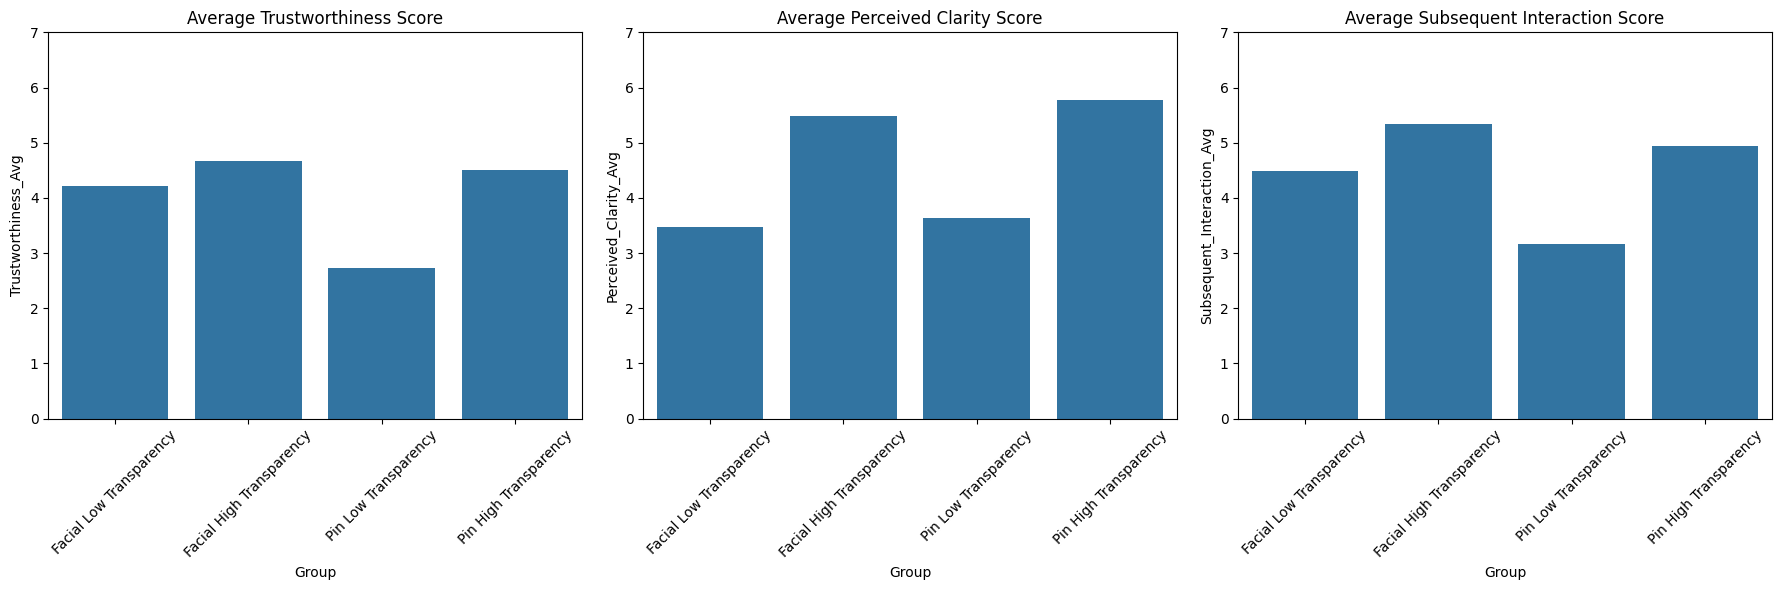

In [11]:
plt.figure(figsize=(18, 6))

# Plot for Trustworthiness Average
plt.subplot(1, 3, 1)
sns.barplot(x='Group', y='Trustworthiness_Avg', data=summary_df)
plt.title('Average Trustworthiness Score')
plt.xticks(rotation=45)
plt.ylim(0, 7)

# Plot for Perceived Clarity Average
plt.subplot(1, 3, 2)
sns.barplot(x='Group', y='Perceived_Clarity_Avg', data=summary_df)
plt.title('Average Perceived Clarity Score')
plt.xticks(rotation=45)
plt.ylim(0, 7)

# Plot for Subsequent Interaction Average
plt.subplot(1, 3, 3)
sns.barplot(x='Group', y='Subsequent_Interaction_Avg', data=summary_df)
plt.title('Average Subsequent Interaction Score')
plt.xticks(rotation=45)
plt.ylim(0, 7)

plt.tight_layout()
plt.show()

# Analysis

## MANOVA

In [12]:
# Define method and transparency for each dataset
facial_low_transparency['Method'] = 'Facial'
facial_low_transparency['Transparency'] = 'Low'

facial_high_transparency['Method'] = 'Facial'
facial_high_transparency['Transparency'] = 'High'

pin_low_transparency['Method'] = 'Pin'
pin_low_transparency['Transparency'] = 'Low'

pin_high_transparency['Method'] = 'Pin'
pin_high_transparency['Transparency'] = 'High'

# Combine into a single DataFrame
combined_data = pd.concat([facial_low_transparency, facial_high_transparency, pin_low_transparency, pin_high_transparency])

# Prepare the new formula for MANOVA
manova_formula = 'Trustworthiness_Avg + Perceived_Clarity_Avg + Subsequent_Interaction_Avg ~ C(demographic_q1) + C(demographic_q2) + C(demographic_q3) + C(demographic_q4) + C(demographic_q5) + C(demographic_q6) + C(Method) + C(Transparency)'

# Perform MANOVA with the updated formula
maov = MANOVA.from_formula(manova_formula, data=combined_data)
print(maov.mv_test())


                  Multivariate linear model
                                                              
--------------------------------------------------------------
         Intercept        Value  Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.7649 3.0000 35.0000  3.5855 0.0232
           Pillai's trace 0.2351 3.0000 35.0000  3.5855 0.0232
   Hotelling-Lawley trace 0.3073 3.0000 35.0000  3.5855 0.0232
      Roy's greatest root 0.3073 3.0000 35.0000  3.5855 0.0232
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
   C(demographic_q1)    Value   Num DF  Den DF  F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda 0.8822 12.0000  92.8928  0.3755 0.9691
         Pillai's trace 0.1220 12.0000 111.0000  0.3922 0.9639
 Hotelling-

In [15]:
# Combine datasets and add a 'Group' column
facial_low_transparency['Group'] = 'Facial Low Transparency'
facial_high_transparency['Group'] = 'Facial High Transparency'
pin_low_transparency['Group'] = 'Pin Low Transparency'
pin_high_transparency['Group'] = 'Pin High Transparency'

# Combine into a single DataFrame
combined_data = pd.concat([facial_low_transparency, facial_high_transparency, pin_low_transparency, pin_high_transparency])

# Prepare the formula for MANOVA
manova_formula = 'Trustworthiness_Avg + Perceived_Clarity_Avg + Subsequent_Interaction_Avg ~ C(demographic_q1) + C(demographic_q2) + C(demographic_q3) + C(demographic_q4) + C(demographic_q5) + C(demographic_q6) + C(Group)'

# Perform MANOVA
maov = MANOVA.from_formula(manova_formula, data=combined_data)

In [13]:
# Data from the MANOVA results
manova_data = {
    "Effect": [
        "Intercept", "C(demographic_q1)", "C(demographic_q2)", "C(demographic_q3)",
        "C(demographic_q4)", "C(demographic_q5)", "C(demographic_q6)", "C(Method)", "C(Transparency)"
    ],
    "Wilks' lambda": [0.7649, 0.8822, 0.6227, 0.5388, 0.8580, 0.7623, 0.9535, 0.7631, 0.7889],
    "F Value": [3.5855, 0.3755, 2.0371, 2.7432, 0.9285, 0.8362, 0.5691, 3.6217, 3.1227],
    "Pr > F": [0.0232, 0.9691, 0.0446, 0.0073, 0.4801, 0.6132, 0.6391, 0.0224, 0.0382]
}

# Creating a DataFrame
manova_results_df = pd.DataFrame(manova_data)

manova_results_df

,Effect,Wilks' lambda,F Value,Pr > F
0,Intercept,0.7649,3.5855,0.0232
1,C(demographic_q1),0.8822,0.3755,0.9691
2,C(demographic_q2),0.6227,2.0371,0.0446
3,C(demographic_q3),0.5388,2.7432,0.0073
4,C(demographic_q4),0.8580,0.9285,0.4801
5,C(demographic_q5),0.7623,0.8362,0.6132
6,C(demographic_q6),0.9535,0.5691,0.6391
7,C(Method),0.7631,3.6217,0.0224
8,C(Transparency),0.7889,3.1227,0.0382


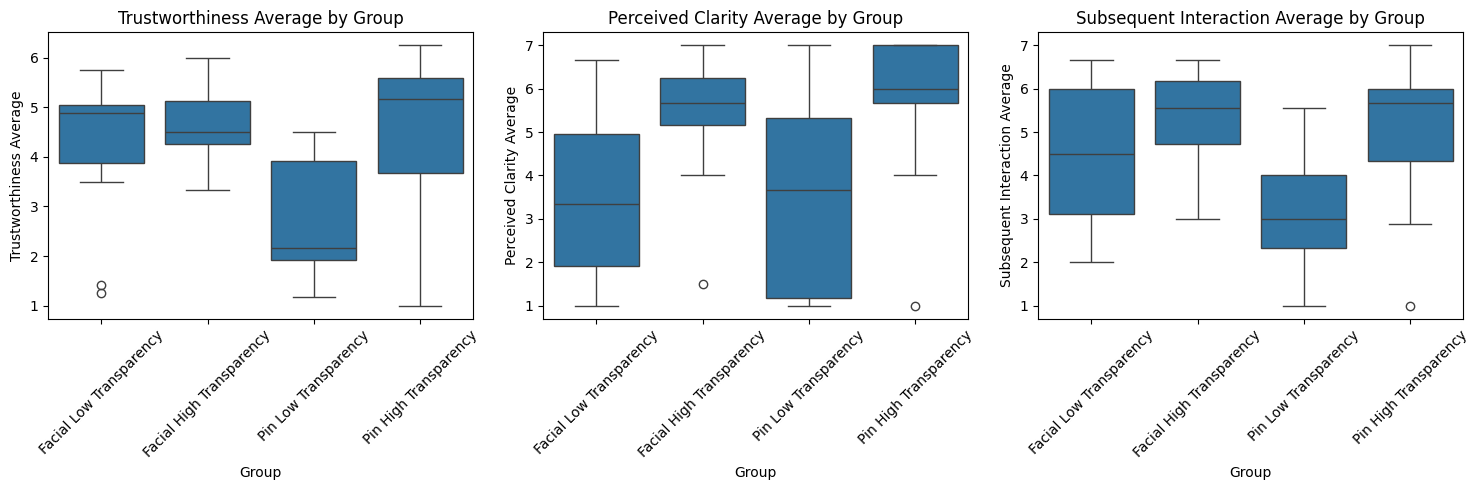

In [16]:
boxplot_data = combined_data[['Trustworthiness_Avg', 'Perceived_Clarity_Avg', 'Subsequent_Interaction_Avg', 'Group']]

# Creating boxplots
plt.figure(figsize=(15, 5))

# Trustworthiness Average
plt.subplot(1, 3, 1)
sns.boxplot(x='Group', y='Trustworthiness_Avg', data=boxplot_data)
plt.title('Trustworthiness Average by Group')
plt.ylabel('Trustworthiness Average')
plt.xticks(rotation=45)

# Perceived Clarity Average
plt.subplot(1, 3, 2)
sns.boxplot(x='Group', y='Perceived_Clarity_Avg', data=boxplot_data)
plt.title('Perceived Clarity Average by Group')
plt.ylabel('Perceived Clarity Average')
plt.xticks(rotation=45)

# Subsequent Interaction Average
plt.subplot(1, 3, 3)
sns.boxplot(x='Group', y='Subsequent_Interaction_Avg', data=boxplot_data)
plt.title('Subsequent Interaction Average by Group')
plt.ylabel('Subsequent Interaction Average')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

## Pair-Wise Testing

In [21]:
# Conduct Tukey's HSD test for Trustworthiness
tukey_trustworthiness = pairwise_tukeyhsd(endog=combined_data['Trustworthiness_Avg'], 
                                          groups=combined_data['Group'],
                                          alpha=0.05)
print("Tukey HSD Test for Trustworthiness:\n", tukey_trustworthiness)

# Conduct Tukey's HSD test for Perceived Clarity
tukey_perceived_clarity = pairwise_tukeyhsd(endog=combined_data['Perceived_Clarity_Avg'], 
                                            groups=combined_data['Group'],
                                            alpha=0.05)
print("\nTukey HSD Test for Perceived Clarity:\n", tukey_perceived_clarity)

# Conduct Tukey's HSD test for Subsequent Interaction
tukey_subsequent_interaction = pairwise_tukeyhsd(endog=combined_data['Subsequent_Interaction_Avg'], 
                                                 groups=combined_data['Group'],
                                                 alpha=0.05)
print("\nTukey HSD Test for Subsequent Interaction:\n", tukey_subsequent_interaction)

Tukey HSD Test for Trustworthiness:
                   Multiple Comparison of Means - Tukey HSD, FWER=0.05                  
         group1                   group2         meandiff p-adj   lower   upper  reject
---------------------------------------------------------------------------------------
Facial High Transparency Facial Low Transparency  -0.4528 0.8117 -1.8071  0.9015  False
Facial High Transparency   Pin High Transparency  -0.1562  0.987 -1.3949  1.0825  False
Facial High Transparency    Pin Low Transparency  -1.9239 0.0018  -3.249 -0.5989   True
 Facial Low Transparency   Pin High Transparency   0.2966 0.9326 -1.0219   1.615  False
 Facial Low Transparency    Pin Low Transparency  -1.4712 0.0359  -2.871 -0.0713   True
   Pin High Transparency    Pin Low Transparency  -1.7677 0.0034 -3.0561 -0.4794   True
---------------------------------------------------------------------------------------

Tukey HSD Test for Perceived Clarity:
                   Multiple Comparison of Me